<a href="https://colab.research.google.com/github/gjoni/trDesign/blob/master/02-GD/notebooks/TrDesign_GD_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash
wget -qnc https://raw.githubusercontent.com/gjoni/trDesign/master/02-GD/models.py
wget -qnc https://raw.githubusercontent.com/gjoni/trDesign/master/02-GD/utils.py
wget -qnc https://raw.githubusercontent.com/gjoni/trDesign/master/02-GD/1QYS.pdb
wget -qnc https://files.ipd.uw.edu/krypton/TrRosetta/design/to_pdb.py
wget -qnc https://files.ipd.uw.edu/krypton/TrRosetta/models.zip
wget -qnc https://files.ipd.uw.edu/krypton/TrRosetta/bkgr_models.zip
unzip -qqo models.zip
unzip -qqo bkgr_models.zip
pip -q install py3Dmol

In [2]:
import numpy as numpy
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.gridspec import GridSpec
from IPython.display import HTML
import py3Dmol

from utils import *
from models import *
from to_pdb import *

Few extra functions for later

In [3]:
def plot_feat(x):
  '''plot each feature'''
  plt.figure(figsize=(4*4,4))
  for n,(k,v) in enumerate(split_feat(x).items()):
    plt.subplot(1,4,n+1); plt.title(k)
    plt.imshow(np.squeeze(v).argmax(-1))
  plt.show()

def animate(design):
  '''animate given trajectory'''
  fig, imgs = plt.figure(figsize=(6,4), dpi=100),[]
  gs = GridSpec(1,4, figure=fig)
  ax1 = fig.add_subplot(gs[0,:3]); ax1.axis(False)
  ax2 = fig.add_subplot(gs[0,3]); ax2.axis(False)
  # go through each step along traj
  for k,out in enumerate(design["traj"]):
    # plot distance (contact map)
    pred = split_feat(out["feat"])["dist"][0].argmax(-1)
    # plot pssm (probability of amino acid at each position)
    pssm = out["pssm"][0,0]
    im1 = ax1.imshow(pred, animated=True)
    im2 = ax2.imshow(pssm, animated=True,vmin=0,vmax=1)
    imgs.append([im1,im2])
  ani = animation.ArtistAnimation(fig, imgs, blit=True, interval=40)
  plt.close()
  return ani.to_html5_video()

def get_pdb(design,pdb_filename="out.pdb"):
  '''show approx. structure'''
  seq = N_to_AA(design["I"].argmax(-1))[0]
  xyz, dm = feat_to_xyz(design["feat"])
  save_PDB(pdb_filename, xyz, dm, seq)

  p = py3Dmol.view()
  p.addModel(open(pdb_filename,'r').read(),'pdb')
  p.setStyle({'cartoon': {'color':'spectrum'}})
  p.zoomTo()
  p.show()

#**PART 1** - hallucination time!

In [4]:
# first we need a background distribution
length = 50
bkg = get_bkg([length])[length]

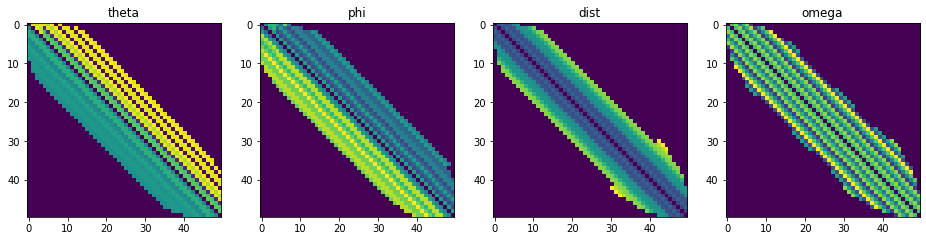

In [5]:
plot_feat(bkg)

In [6]:
# WARNING, for demo we use n_models=1, in practice you should ALWAYS use n_models=5
# note, for hallucination design we find that "sample" mode works better
model = mk_design_model(add_bkg=True, n_models=1, sample=True)

mode: single sequence design
loading model: xaa
The loss function is composed of the following: ['bkg']


In [7]:
# note return_traj=True will return the predicted structure at EVERY iteration
# you'll quickly run out of memory, should only be used for demo/analysis.
design = model.design(inputs={"bkg":bkg[None]}, return_traj=True, opt_iter=200)

10 loss:{'bkg':-0.37600425}
20 loss:{'bkg':-0.74751955}
30 loss:{'bkg':-1.0172043}
40 loss:{'bkg':-1.1926103}
50 loss:{'bkg':-1.2813053}
60 loss:{'bkg':-1.32751}
70 loss:{'bkg':-1.3428952}
80 loss:{'bkg':-1.3445626}
90 loss:{'bkg':-1.3550375}
100 loss:{'bkg':-1.3519244}
110 loss:{'bkg':-1.3371221}
120 loss:{'bkg':-1.3566433}
130 loss:{'bkg':-1.3546664}
140 loss:{'bkg':-1.3528278}
150 loss:{'bkg':-1.3619516}
160 loss:{'bkg':-1.3640908}
170 loss:{'bkg':-1.3617224}
180 loss:{'bkg':-1.3635185}
190 loss:{'bkg':-1.3590415}
200 loss:{'bkg':-1.3297004}
FINAL loss:{'bkg':-1.3450824}


In [8]:
# the reported loss it the Kullback–Leibler divergence between the predicted features and the background
-(design["feat"] * np.log(design["feat"]/bkg)).sum(-1).mean()/4

-1.3450829982757568

In [9]:
# sequence of the design
N_to_AA(design["I"].argmax(-1))

['KIKTVQCEYPWDDCEDLMDECADDGYRIMINMEKTDGKCRMQMQVFPPGA']

In [10]:
HTML(animate(design))

## But.. but, how do I see my protein... in 3D?
Normally we'd input the predicted constraints into PyRosetta... but since this is quite expensive to run, for demo purposes let's use an approximation!

In [11]:
get_pdb(design)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

#**PART 2** - Design a new sequence for a given protein backbone!

## Load features from PDB

In [12]:
pdb = prep_input("1QYS.pdb", chain="A")
_feat = pdb["feat"]
_seq = np.eye(20)[AA_to_N(pdb["seq"])]

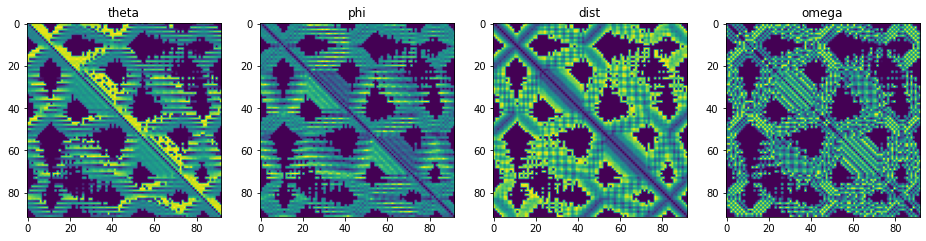

In [13]:
plot_feat(_feat)

## setup design run

In [14]:
# WARNING, for demo we use n_models=1, in practice you should ALWAYS use n_models=5
model = mk_design_model(add_pdb=True, n_models=1)

mode: single sequence design
loading model: xaa
The loss function is composed of the following: ['pdb']


make a prediction using native sequence

In [15]:
pred = model.predict(inputs={"I":_seq[None,None],"pdb":_feat[None]})

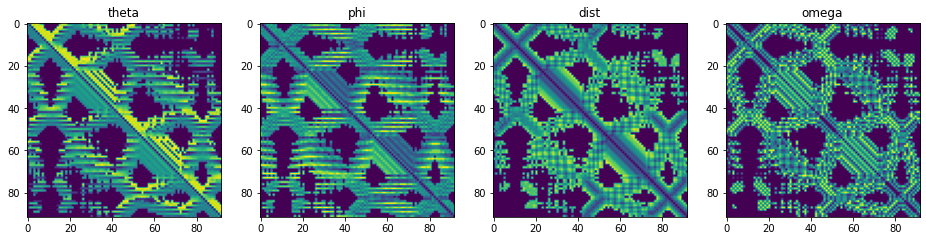

In [16]:
plot_feat(pred["feat"])

In [17]:
# measure of contact accuracy
get_dist_acc(pred["feat"],_feat)

array([0.7734046])

## Let's design a new sequence!

In [18]:
design = model.design(inputs={"pdb":_feat[None]}, return_traj=True)

10 loss:{'pdb':2.1402955}
20 loss:{'pdb':1.5531884}
30 loss:{'pdb':1.4175739}
40 loss:{'pdb':1.3696092}
50 loss:{'pdb':1.3427638}
60 loss:{'pdb':1.3249362}
70 loss:{'pdb':1.3178452}
80 loss:{'pdb':1.3102658}
90 loss:{'pdb':1.3054754}
100 loss:{'pdb':1.3374841}
FINAL loss:{'pdb':1.2886981}


In [19]:
# the reported loss it the categorical cross entropy
-(_feat * np.log(design["feat"])).sum(-1).mean()/4

1.2886981074146593

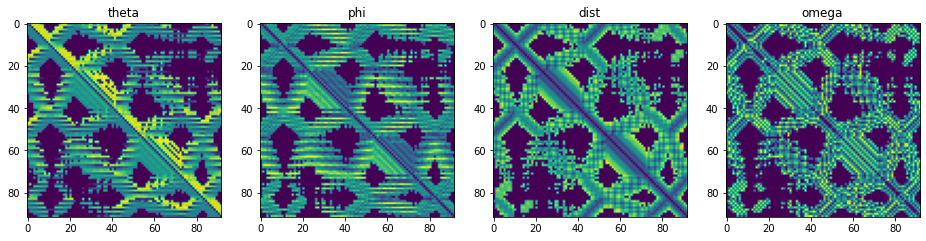

In [20]:
plot_feat(design["feat"])

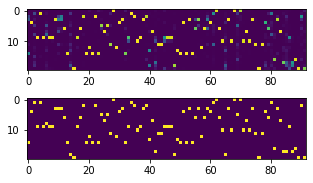

['PCRIRIHIIDDDEPYVIENPMPNPQGQKAMCDPIRNLIDNFGWKKIIIYFPCPDPEDMEDCRAELYDLAQALGLDKVKCERTDGWWIWTVNV']

In [21]:
plt.figure(figsize=(5,3))
plt.subplot(2,1,1)
plt.imshow(design["I_pssm"][0].T)
plt.subplot(2,1,2)
plt.imshow(np.eye(20)[design["I"][0].argmax(-1)].T)
plt.show()

N_to_AA(design["I"].argmax(-1))

## Let's make a movie!

In [22]:
HTML(animate(design))

In [23]:
get_pdb(design)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol